# Career Track Capstone Project 1
## Data Cleaning Part II and Data wrangling
We filled the missing values of the 'postal-code', and corrected the values of the 'city'.  Next we will group the 'categories' variable. Each business observation has a different description of the 'categories'.  We need to group all observations into 9 to 10 category groups. Another job is to import the 'checkin.json'  and the 'reivew.json', and extract relative variables combining with the business dataframe.

### Import libraries and data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import difflib
import re
import datetime
from sklearn.model_selection import train_test_split

We read the CSV file saved prior. 

In [6]:
business_org = pd.read_csv("business_usa_filled_postal-city.csv",index_col=0)

### Check data
Now we need to check the 'categories' variable. 

In [7]:
bs=business_org[business_org['categories']== '[]']

In [8]:
bs.city.value_counts()

Phoenix                 77
Las Vegas               77
Mesa                    24
Charlotte               19
Glendale                17
Tempe                   16
Scottsdale              15
North Las Vegas         11
Henderson               11
Chandler                 9
Pittsburgh               6
Madison                  6
Cleveland                5
Avondale                 5
Gilbert                  4
Peoria                   4
Matthews                 4
Strongsville             3
Champaign                3
Verona                   3
McMurray                 2
Hudson                   2
Bedford                  2
Lorain                   2
Concord                  2
Euclid                   2
Goodyear                 2
Surprise                 2
Mount Oliver             2
Avon                     2
                        ..
Seven Hills              1
Cuyahoga Falls           1
Sewickley                1
Turtle Creek             1
El Mirage                1
Beachwood                1
P

We find some observations which don't have any content in the 'categories' column. The number of those observations is not so big comparing to 120 thousand. So we just drop them because we don't know how to fill those missing values.

In [9]:
business = business_org[business_org['categories']!= '[]']
business = business.reset_index(drop=True)

Variables, such as the 'attribute' and the 'is_open', we don't need them right now. So we choose the variables we need to form into a tidy dataframe.

In [10]:
columns_sel = ['business_id','categories','city','hours','latitude','longitude','name','postal_code',
                'review_count','stars','state']
business = business[columns_sel]

### Make all businesses into nine groups

The contents in the 'categories' column don't have a standard format. Here we write a function (clean_categories) to clean it for extracting meaningful words. 

For grouping businesses, we need to create a dictionary including common meaningful words for each group. Then we need to calculate words' frequencies in the contents of the 'categories' column. For this reason, we write the 'keyword_count' function to do it. 

The 'business_grouping' and the 'get_grouplabel' are to evaluate the content of each observation in the 'categories', and create a group label for the observation as a new variable. 

In [11]:

def clean_categories(cat) :
    reg = re.compile('[^a-zA-Z]')
    cat_dict = {}
    for index, row in cat.iteritems() :
        words = reg.sub(' ', row.strip())        
        words = re.sub( '\s+', ' ', words.strip()).strip()        
        words = words.split(' ')       
        c_list = [x.lower() for x in words]
        c_list.sort()
        cat_dict[index] = ','.join(c_list).strip()
    return pd.Series(cat_dict)

def keyword_count(cat):
    keyword_dict={}
    reg = re.compile('[^a-zA-Z]')
    for index, row in cat.iteritems() :
        words = reg.sub(' ', row.strip()) 
        words = re.sub( '\s+', ' ', words.strip()).strip() 
        words = words.split(' ')
        for word in words:
            if (word not in keyword_dict) :
                keyword_dict[word] = 1
            else:
                keyword_dict[word] +=1
                
    return keyword_dict

def get_grouplabel(words):
    group_label = []
    word_list = words.split(',')
    for word in word_list:
        for key, group in groups_dict.items():
            if word in group:
                if len(group_label) == 0:
                    group_label.append(key)
    if len(group_label) == 0:
        group_label.append('Other Professional Service')
    return group_label[0]

def business_grouping(categories):
    groups_dict = {}
    for index,row in categories.iteritems():
        if (len(row)==0):
            print(index)
        group_label = get_grouplabel(row)
        groups_dict[index] = group_label
    return groups_dict

Calculate the frequency of each word in the 'categories', and sort the results with the descending order. Then we will know the most words used in the column.

In [12]:
keywords = keyword_count(business.categories)
sorted(keywords.items(), key=lambda x:x[1],reverse=True)

[('Services', 51465),
 ('Restaurants', 32244),
 ('Food', 24729),
 ('Home', 23367),
 ('Shopping', 21632),
 ('Spas', 15787),
 ('Beauty', 14764),
 ('Medical', 14608),
 ('Health', 13417),
 ('Bars', 12545),
 ('Hair', 10770),
 ('Local', 10331),
 ('Repair', 9972),
 ('Automotive', 9721),
 ('Event', 9418),
 ('American', 9080),
 ('Salons', 8736),
 ('Stores', 8636),
 ('Planning', 8443),
 ('Auto', 8418),
 ('Nightlife', 7889),
 ('Estate', 6965),
 ('Life', 6896),
 ('Real', 6801),
 ('Active', 6477),
 ('Arts', 6415),
 ('Hotels', 5826),
 ('Pet', 5546),
 ('Fashion', 5274),
 ('Traditional', 5207),
 ('Dentists', 4833),
 ('Sandwiches', 4652),
 ('Fast', 4608),
 ('Doctors', 4428),
 ('Garden', 4413),
 ('Professional', 4404),
 ('Entertainment', 4372),
 ('Travel', 4329),
 ('Pizza', 4279),
 ('Shops', 4222),
 ('s', 4010),
 ('Care', 3988),
 ('New', 3713),
 ('Mexican', 3576),
 ('Nail', 3487),
 ('Clothing', 3469),
 ('Cleaning', 3464),
 ('Car', 3404),
 ('Fitness', 3281),
 ('Specialty', 3242),
 ('Instruction', 3238),


Here we create nine groups for all business observations. 

Each group has a list containing common meaningful words as the representation of this group.

The group of the 'Nearby Services' includes all businesses which people need in their routine life, such as hair salons, post offices, banks, etc.. These businesses usually are near around people's home or offices.

Many entertainment places also offer catering service, especially in Las Vegas NV. So we let them in the same group.

We combine fitness, health care, recreation center together, because those businesses are all about people's health.

In some specific case, we need professional service, such as investment, tax, and legal issues, etc.. These businesses are grouped with the label of 'Other Professional Service'. 

In [13]:

group1 = ['Parks','Park','Libraries','Library','Cinema','Theatre','Museums','Stadiums','government',
          'historical','landmarks','public','community']

group2 = ['shopping', 'stores','store','shops','shop','Grocery','Drugstores','Books','Book stores',
  'Pharmacy','Gun','Souvenir','Galleries']

group3 = ['Schools','school','Education','preschools','university','Universities','College','colleges']

group4 = ['home','contractors','Furniture','Decor','Electronics','door','Heating','Conditioning','pest','cleaner','cleaners',
          'cleaning','Landscaping','Carpet','Plumbing','Flooring','sewer','tub','Kitchen','home security',
   'Bath','Mattresses','Handyman','Gardening','Pools','Heater','Locksmiths','Roofing','appliances',
   'Garage','Inspectors','movers','removal','electricians','architects','delivery']

group5 = ['salons', 'salon','Barbers','Spas','Hair','Tattoo','Beauty','Laundry','Pets','pet','Photographers','storage','recycling',
          'Florists','Wedding','Massage','Sewing','shoe repair','day care','child','bike repair','watch repair',
          'Banks','Post','Churches','religious','synagogues']

group6 = ['Caterers','caterer','restaurants','restaurant','food','tea','coffee','Breakfast','lunch','dinner','Brunch',
   'Steakhouses','bars','bar','cafeteria','cafes','cafe','Bakeries','bakerie','Yogurt','clubs','dance','nightlife',
         'hotels', 'hotel','Performing Arts','Entertainment','Resorts','resort','hotel','Casinos','Travel','Tours']

group7 = ['fitness','gyms','gym','golf','Yoga','Recreation','Stadiums','Stadium','Dentistry', 'Dentists','Doctors','health care',
          'Hospital','Hospitals','Gynecologists','Obstetricians','Ophthalmologists','Pediatricians',
          'Naturopathic','Podiatrists','Clinics','Chiropractors','Therapy','Pediatric','Acupuncture',
          'Nutritionists','medical','health','life']

group8 = ['automotive', 'auto','car','cars','motor','Motorcycle',
          'Transportation', 'Bus', 'train','Airport','Parking','boating','Gas']

group9 = ['Insurance','Tax','accountants','financial','investing','Estate','Law','bail','legal','investigation',
          'lawyers','lawyer','notaries','advertising','marketing','employment','career','design','graphic','printing',
          'print','computer','video','Funeral','propane','instrument','appraisal','professional','consulting']

groups_dict = {
    'Public Facilities':[x.lower() for x in group1],
    'Shopping':[x.lower() for x in group2],
    'Education':[x.lower() for x in group3],
    'House-inside Services' : [x.lower() for x in group4], 
    'Nearby Services':[x.lower() for x in group5],
    'Entertainment & Catering' :[x.lower() for x in group6],
    'Fitness,Health Care':[x.lower() for x in group7],
    'Auto,Transportation':[x.lower() for x in group8],
    'Other Professional Service':[x.lower() for x in group9]}


Now we can group all businesses' observations.

In [15]:
cat_clean = clean_categories(business.categories)
cat_groups_dict = business_grouping(cat_clean)
cat_groups = pd.Series(cat_groups_dict)
business['cat_groups'] = cat_groups

In [17]:
business.cat_groups.value_counts()

Entertainment & Catering      46548
Nearby Services               19751
House-inside Services         15225
Fitness,Health Care           13945
Auto,Transportation           10887
Other Professional Service     9177
Shopping                       9147
Education                      1276
Public Facilities              1233
Name: cat_groups, dtype: int64

Via the value_counts() function of Pandas, we can find that the most three businesses are 'Entertainment & Catering',
'Nearby Services' and 'House-inside Services'.

### Import 'checkin' and 'review' datasets
The 'checkin' dataset has a 'time' variable containing one week's time series of checking in. We can merge it into business dataframe for using later. We change the name of 'time' into 'checkin_time'.

In [18]:
file_checkin = 'checkin.json'
checkin_js = [json.loads(line) for line in open(file_checkin)]
checkin_unclean = pd.DataFrame(checkin_js)

business=pd.merge(business,checkin_unclean,on=['business_id'],how='left')
business = business.rename(columns={'time':'checkin_time'})

In [2]:
file_review = 'review.json'
review_js = [json.loads(line) for line in open(file_review)]
review_unclean = pd.DataFrame(review_js)

The 'review_unclean' dataframe contain the content of each review in the 'text' column, and other users' votes for each review in the columns of 'useful','cool' and 'funny'. The size of the 'review.json' is more than 4 gigabytes. We don't need the 'text' variable right now. So we make a review_tidy dataframe without the 'text' column.

In [64]:
review_tidy = review_unclean[['review_id','user_id','business_id','stars','date','useful','funny','cool']]
review_tidy.to_csv("{}_{}.csv".format('review_tidy',datetime.datetime.now()))

We can save the contents of 'text' variable into a CSV file for using later.

In [4]:
review_contents = review_unclean[['review_id','user_id','business_id','text','stars','date']]
review_contents.to_csv("{}_{}.csv".format('review_contents',datetime.datetime.now()))

In [3]:
review_contents = review_unclean[['review_id','user_id','business_id','text','stars','date']]

In [5]:
sum(pd.isna(review_contents['text']))

0

In [7]:
Text = review_contents.text
stars = review_contents.stars


In [16]:
Text_1, Text_2, stars_1, stars_2 = train_test_split(Text, stars, test_size=0.8) 
pd.DataFrame(Text_1).to_csv('./data/Yelp_text1.csv')
pd.DataFrame(Text_2).to_csv('./data/Yelp_text2.csv')
pd.DataFrame(stars_1).to_csv('./data/Yelp_stars1.csv')
pd.DataFrame(stars_2).to_csv('./data/Yelp_stars2.csv')

In [22]:
Text_3, Text_4, stars_3, stars_4 = train_test_split(Text_1, stars_1, test_size=0.8) 
pd.DataFrame(Text_3).to_csv('./data/Yelp_text3.csv')
pd.DataFrame(Text_4).to_csv('./data/Yelp_text4.csv')
pd.DataFrame(stars_3).to_csv('./data/Yelp_stars3.csv')
pd.DataFrame(stars_4).to_csv('./data/Yelp_stars4.csv')

In [24]:
Text_5, Text_6, stars_5, stars_6 = train_test_split(Text_3, stars_3, test_size=0.5) 
pd.DataFrame(Text_5).to_csv('./data/Yelp_text5.csv')
pd.DataFrame(Text_6).to_csv('./data/Yelp_text6.csv')
pd.DataFrame(stars_5).to_csv('./data/Yelp_stars5.csv')
pd.DataFrame(stars_6).to_csv('./data/Yelp_stars6.csv')

### Aggregation review observations for each business
Because each 'business_id' has multiple review observations in the 'review_tidy' dataframe. We summarize 'useful', 'cool' and 'funny' columns for each 'business_id' forming into a new dataframe 'review_stats'. We also create a new variable 'review_votes' as the sum number of 'useful', 'cool' and 'funny'.

In [20]:
review_stats = review_tidy.groupby('business_id')[['useful','funny','cool','stars']].agg({'useful':'sum',
                                                                    'funny':'sum','cool':'sum','stars':'mean'})

In [21]:
review_stats['review_votes'] = review_stats.useful + review_stats.funny + review_stats.cool 

In [22]:
review_stats=review_stats.reset_index()

Now we can merge the 'review_stats' dataframe with the 'business' dataframe.

In [23]:
business=pd.merge(business,review_stats[['business_id','review_votes','useful','funny','cool']],
                  on=['business_id'],how='left')

### Plots
Now we can plot the 'review_count' and the 'review_votes' categorized by states.

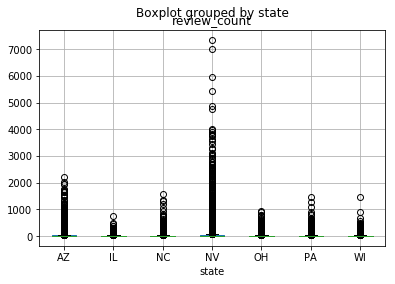

In [25]:
business.boxplot(column='review_count',by='state')
plt.show()

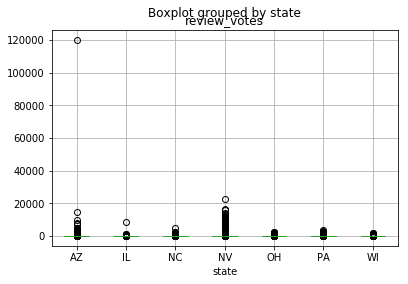

In [26]:
business.boxplot(column='review_votes',by='state')
plt.show()

### Correct the outlier
Some businesses have more than seven thousand reviews. It can make sense because these businesses located in Las Vegas NV. But a business, which has more than 120 thousand review votes corresponding 461 reviews, is abnormal. Wee need to correct it with giving the mean values of related columns.

In [27]:
business[business['review_votes']>=110000]

,business_id,categories,city,hours,latitude,longitude,name,postal_code,review_count,stars,state,cat_groups,checkin_time,review_votes,useful,funny,cool
45188,DN0b4Un8--Uf6SEWLeh0UA,"['American (New)', 'Pizza', 'Bakeries', 'Itali...",Scottsdale,"{'Tuesday': '12:00-21:00', 'Friday': '12:00-21...",33.584012,-111.922265,Amy's Baking Company,85260,461,3.0,AZ,Entertainment & Catering,"{'Friday': {'19:00': 3, '18:00': 2, '22:00': 3...",120162,61488,49396,9278


In [28]:

business.review_votes.loc[45188]= np.mean(business.review_votes)
business.useful.loc[45188] = np.mean(business.useful)
business.funny.loc[45188] = np.mean(business.funny)
business.cool.loc[45188] = np.mean(business.cool)

business.review_votes = business.review_votes.astype(int)
business.useful = business.useful.astype(int)
business.funny = business.funny.astype(int)
business.cool = business.cool.astype(int)


/Users/chrisyang/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:194: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [29]:
business.loc[45188]

business_id                                DN0b4Un8--Uf6SEWLeh0UA
categories      ['American (New)', 'Pizza', 'Bakeries', 'Itali...
city                                                   Scottsdale
hours           {'Tuesday': '12:00-21:00', 'Friday': '12:00-21...
latitude                                                   33.584
longitude                                                -111.922
name                                         Amy's Baking Company
postal_code                                                 85260
review_count                                                  461
stars                                                           3
state                                                          AZ
cat_groups                               Entertainment & Catering
checkin_time    {'Friday': {'19:00': 3, '18:00': 2, '22:00': 3...
review_votes                                                   87
useful                                                         48
funny     

### Save Data
Now we can save our cleaned data for the exploratory data analysis!

In [30]:
business.to_csv("{}_{}.csv".format('business_clean',datetime.datetime.now()))